# Depuracion de datos mixtos

El presente notebook realiza la exploración inicial y depuración de datos agregados de vegetación consolidados por el SMBYC.
Se requieren los siguientes archivos:

1. `asignacion`: Tabla en formato csv. Contiene información básica de las parcelas (ubicación, custodio, etc.).
2. `individuos`: Tabla en formato csv. Contiene medidas y demás datos relacionos con los individuos (diámetro, altura, parcela, placa, etc.). 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Asignar nombres de archivos a variables
asignacion = "data/quimera/asignacion.csv"
individuos =  "data/quimera/newind.csv"

In [2]:
#asig = pd.read_csv(asignacion)
ind = pd.read_csv(individuos, low_memory=False) # low_memory asume que los datos estan homogeneamente tipificados. 

### Variables para los nombres de las columnas

A continuación se adjudica una variable a cada nombre de la columna en ambos archivos. Si los nombres no son los mencionados deben ser actualizados en concordancia. 

In [3]:
FID = 'FID' # Indice de medicion (int)
Plot = 'Plot' # Indice parcela (int)
D = 'D'# Diametro del tallo en cm (float)
H = 'H' # Altura total del tallo en m (float)
X = 'X' # Coordenada X en m (float)
Y = 'Y' # Coordenada Y en m (float)
Placa = 'Placa' # Placa de referencia del individuo (str, aunque la mayoria son int)
Densidad = 'Densidad' # Densidad de la madera en gr/ml (float)
Fuente_densidad = 'Fuente_densidad' # Referencia bibliografica de la densidad de la madera (str)
Habito = 'Habito' # Clasificacion de referencia (str: 'Arborea', 'Palma', 'No-Arborea', 'Exotica', 'Paramo', 'Mangle').
Entra_calculos = 'Entra_calculos' # Inclusion en analisis (str: 'Si', 'No')
Familia = 'Familia' # Familia taxonomica (str)
Autor_familia = 'Autor_familia' # Autor familia taxonomica (str)
Genero = 'Genero' # Genero taxonomica (str)
Autor_genero = 'Autor_genero' # Autor genero taxonomica (str)
Estado_epiteto = 'Estado_epiteto' # Incertidumbre de la determinacion especifica (str: 'aff.', 'cf.', 'vs.', 'gr.')
Epiteto = 'Epiteto' # Epiteto especifico, si indeterminado a especie contiene 'sp.' (str)
Autor_especie = 'Autor_especie' # Autor epiteto taxonomico (str)
Morfoespecie = 'Morfoespecie' # Concatenacion de los campos Genero y Epiteto (str).

fields_asig = [FID, Plot, D, H, X, Y, Placa, Densidad, Fuente_densidad, Habito, Entra_calculos, Familia, Autor_familia, Genero, Autor_genero, Estado_epiteto, Epiteto, Autor_especie, Morfoespecie]


### Verificar si las columnas tienen el tipo de dato apropiado

In [4]:
# Verificar si todas las columnas tienen el tipo de dato adecuado
for fi in [FID, Plot]:
    if ind[fi].dtype != np.int64:
        print "Campo {0} tiene tipo inapropiado ({1} en vez de int64).".format(fi, ind[fi].dtype)
        
for fi in [D, H, X, Y, Densidad]:
    if ind[fi].dtype != np.float64:
        print "Campo {0} tiene tipo inapropiado ({1}en vez de float64).".format(fi, ind[fi].dtype)
        
for fi in [Placa, Fuente_densidad, Habito, Familia, Autor_familia, Genero, Autor_genero, Estado_epiteto, Epiteto, Autor_especie, Morfoespecie]:
    non_strings = ind[fi].dropna()[~ind[fi].dropna().apply(type).eq(str)]
    if len(non_strings):
        print "Campo {0} tiene tipo inapropiado ({1} en vez de str).".format(fi, non_strings.dtype)

try:
    ind[Entra_calculos].replace(to_replace = ['Si','No'], value = [True, False], inplace = True)
except TypeError, ErrorMessage:
    if ErrorMessage.args[0] == "Cannot compare types 'ndarray(dtype=bool)' and 'str'":
        pass
    else:
        raise
except:
    raise

if ind[Entra_calculos].dtype != np.bool_:
    print "Campo {0} tiene tipo inapropiado ({1} en vez de str).".format(Entra_calculos, ind[Entra_calculos].dtype)

### Verificar si los valores estan en el rango apropiado

In [5]:
# Indice no debe contener duplicado
if len(ind[FID][ind[FID].duplicated()]):
    print "Tabla {0} contiene indices duplicados.".format(individuos)
    
# Rango de diametro = 10-770 (diametro de General Sherman)
if ind[D].min() < 10:
    print "Existen valores de diametro inferiores a 10 cm"
if ind[D].max() > 770:
    print "Existen valores de diametro dudosamente altos"


In [6]:
def weibull(diameter, a = 42.574, b = 0.0482, c = 0.8307):
    """
    Weibull function to estimate tree height (Feldpausch et al. 2012, 
    Biogeosciences 9:3381-3403, eq 5). Requires know values of coefficients
    a, b, and c.
    
    """
    height = a * (1.0-np.exp(-b * diameter ** c))
    return height

In [10]:
print weibull(20)
print weibull(25)
print weibull(30)

18.7491347241
21.4057287825
23.6913852612


In [30]:
print 10.92-(2*4.06),10.92+(2*4.06)

2.8 19.04


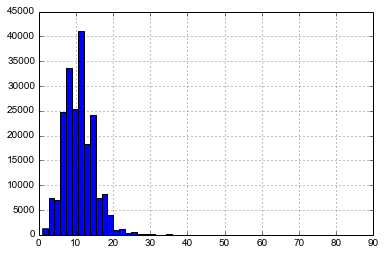

In [28]:
ind.H[(ind.D >= 10) & (ind.D < 20)].hist(bins=50)

In [29]:
ind.H[(ind.D >= 10) & (ind.D < 20)].describe()

count    205852.000000
mean         10.919502
std           4.059461
min           1.100000
25%           8.000000
50%          11.000000
75%          13.000000
max          80.200000
Name: H, dtype: float64

10 20
1261
5800
Axes(0.125,0.125;0.775x0.775)

20 30
1405
2433
Axes(0.125,0.125;0.775x0.775)

30 40
348
1006
Axes(0.125,0.125;0.775x0.775)

40 50
137
644
Axes(0.125,0.125;0.775x0.775)

50 60
88
213
Axes(0.125,0.125;0.775x0.775)

60 70
98
131
Axes(0.125,0.125;0.775x0.775)

70 80
31
83
Axes(0.125,0.125;0.775x0.775)

80 90
35
24
Axes(0.125,0.125;0.775x0.775)

90 100
21
24
Axes(0.125,0.125;0.775x0.775)

100 110
14
8
Axes(0.125,0.125;0.775x0.775)

110 120
11
9
Axes(0.125,0.125;0.775x0.775)

120 130
12
8
Axes(0.125,0.125;0.775x0.775)

130 140
1
9
Axes(0.125,0.125;0.775x0.775)

140 150
4
7
Axes(0.125,0.125;0.775x0.775)

150 160
1
2
Axes(0.125,0.125;0.775x0.775)

160 170
0
2
Axes(0.125,0.125;0.775x0.775)

170 180
0
1
Axes(0.125,0.125;0.775x0.775)

180 190
2
1
Axes(0.125,0.125;0.775x0.775)

190 200
4
0
Axes(0.125,0.125;0.775x0.775)

200 210
2
0
Axes(0.125,0.125;0.775x0.775)

210 220
1
0
Axes(0.125,0.125;0.775x0.775)

220 230
1
0
Axes(0.125,0.125;0.775x0.775)

250 260
1
0
Axes(0.125,0.125;0.775x

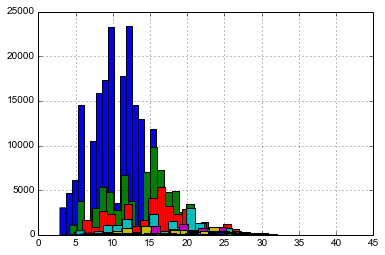

In [45]:
for d in range(10,450,10):
    heights = ind.H[(ind.D >= d) & (ind.D < (d+10))]
    if len(heights) > 20:
        mean = heights.mean()
        std = heights.std()
        print d, d+10
        print len(ind[(ind.D >= d) & (ind.D < (d+10)) & (ind.H < (mean - 2*std))])
        print len(ind[(ind.D >= d) & (ind.D < (d+10)) & (ind.H > (mean + 2*std))])
        print ind.H[(ind.D >= d) & (ind.D < (d+10)) & (ind.H < (mean + 2*std)) & (ind.H > (mean - 2*std))].hist(bins=20)
        print ""

In [ ]:
ind.st

In [12]:
import gdal

In [13]:
E_raster = gdal.Open('Chave_E/E.bil')
transform = E_raster.GetGeoTransform()
xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = transform[5]
E_band = E_raster.GetRasterBand(1)

In [14]:
def getE(longitude, latitude):
    px = int((longitude - xOrigin) / pixelWidth) #x pixel
    py = int((latitude - yOrigin) / pixelHeight) #y pixel
    intval = E_band.ReadAsArray(px,py,1,1)
    return intval[0][0]

In [15]:
def chave(diameter, longitude, latitude):
    E = getE(longitude, latitude)
    logH = 0.893 - E + 0.760 * np.log(diameter) - 0.0340 * np.log(diameter)**2
    height = np.exp(logH + 0.5 * 0.243**2)
    return height

In [16]:
print chave(20, -70, -3)
print chave(25, -70, -3)
print chave(30, -70, -3)

19.3461034737
21.8659500974
24.1059242591


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


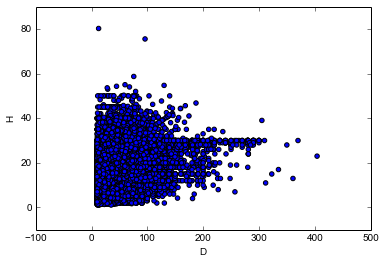

In [18]:
ind.plot.scatter(x=D, y=H)